In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, pearsonr, spearmanr
from sklearn.metrics import average_precision_score, roc_auc_score
from tabulate import tabulate

from variant_tasks import *

In [5]:
# 设置工作目录
os.environ['DART_WORK_DIR'] = '/data1/Mamba/Dataset/Genome/DART-Eval'
work_dir = os.environ.get("DART_WORK_DIR", "")
model_path = os.path.join(work_dir, "task_5_variant_effect_prediction/outputs/zero_shot/likelihoods")

# 模型信息
model_names = [
    "nucleotide-transformer-v2-500m-multi-species",
]
models = ["Nucleotide Transformer"]

In [6]:
def evaluate_model_variant_effects(model_name, model_label, dataset_func, effect_func):
    """
    通用评估函数，适用于不同的数据集（如 Afr、Yoruba）
    """
    dataset_name = dataset_func.__name__
    filename = "Afr.CaQTLS.tsv" if "Afr" in dataset_name else "yoruban.dsqtls.benchmarking.tsv"
    df_ctrl, df_sig = dataset_func(f"{model_path}/{model_name}/{filename}")
    df_ctrl, ctrl_scores = compute_change(df_ctrl)
    df_sig, sig_scores = compute_change(df_sig)

    stat, pval = mannwhitneyu(ctrl_scores, sig_scores, alternative="less")
    pearson, spearman = effect_func(df_sig, "", "log likelihood ratio")
    auprc, auroc = get_precision_recall_auc(ctrl_scores, sig_scores)

    print(f"{model_label} {dataset_name} p-value: {pval}")
    print(f"{model_label} {dataset_name} AUPRC: {auprc}, AUROC: {auroc}, Pearson: {pearson}, Spearman: {spearman}\n")

    return [pval, auprc, auroc, pearson, spearman]

def run_all_evaluations(selected_dataset="both"):
    afr_metrics = []
    yoruba_metrics = []

    for model_name, model in zip(model_names, models):
        if selected_dataset in ["both", "afr"]:
            afr_result = evaluate_model_variant_effects(
                model_name, model,
                dataset_func=sig_ctrl_variants_Afr_CaQTLs,
                effect_func=beta_logfc
            )
            afr_metrics.append(afr_result)

        if selected_dataset in ["both", "yoruba"]:
            yoruba_result = evaluate_model_variant_effects(
                model_name, model,
                dataset_func=variants_Yoruba_LCL_dsQTLs,
                effect_func=est_size_logfc
            )
            yoruba_metrics.append(yoruba_result)

    return afr_metrics, yoruba_metrics

def display_results(afr_metrics, yoruba_metrics):
    index = ["P value", "AUPRC", "AUROC", "Pearson", "Spearman"]
    mydata = []

    if afr_metrics:
        afr_data = [["African " + metric] + list(val) for metric, val in zip(index, zip(*afr_metrics))]
        mydata += afr_data

    if yoruba_metrics:
        yoruba_data = [["Yoruba " + metric] + list(val) for metric, val in zip(index, zip(*yoruba_metrics))]
        mydata += yoruba_data

    print(tabulate(mydata, headers=["Metric"] + models, tablefmt="grid"))

unique label values label
False    77999
True      6821
Name: count, dtype: int64


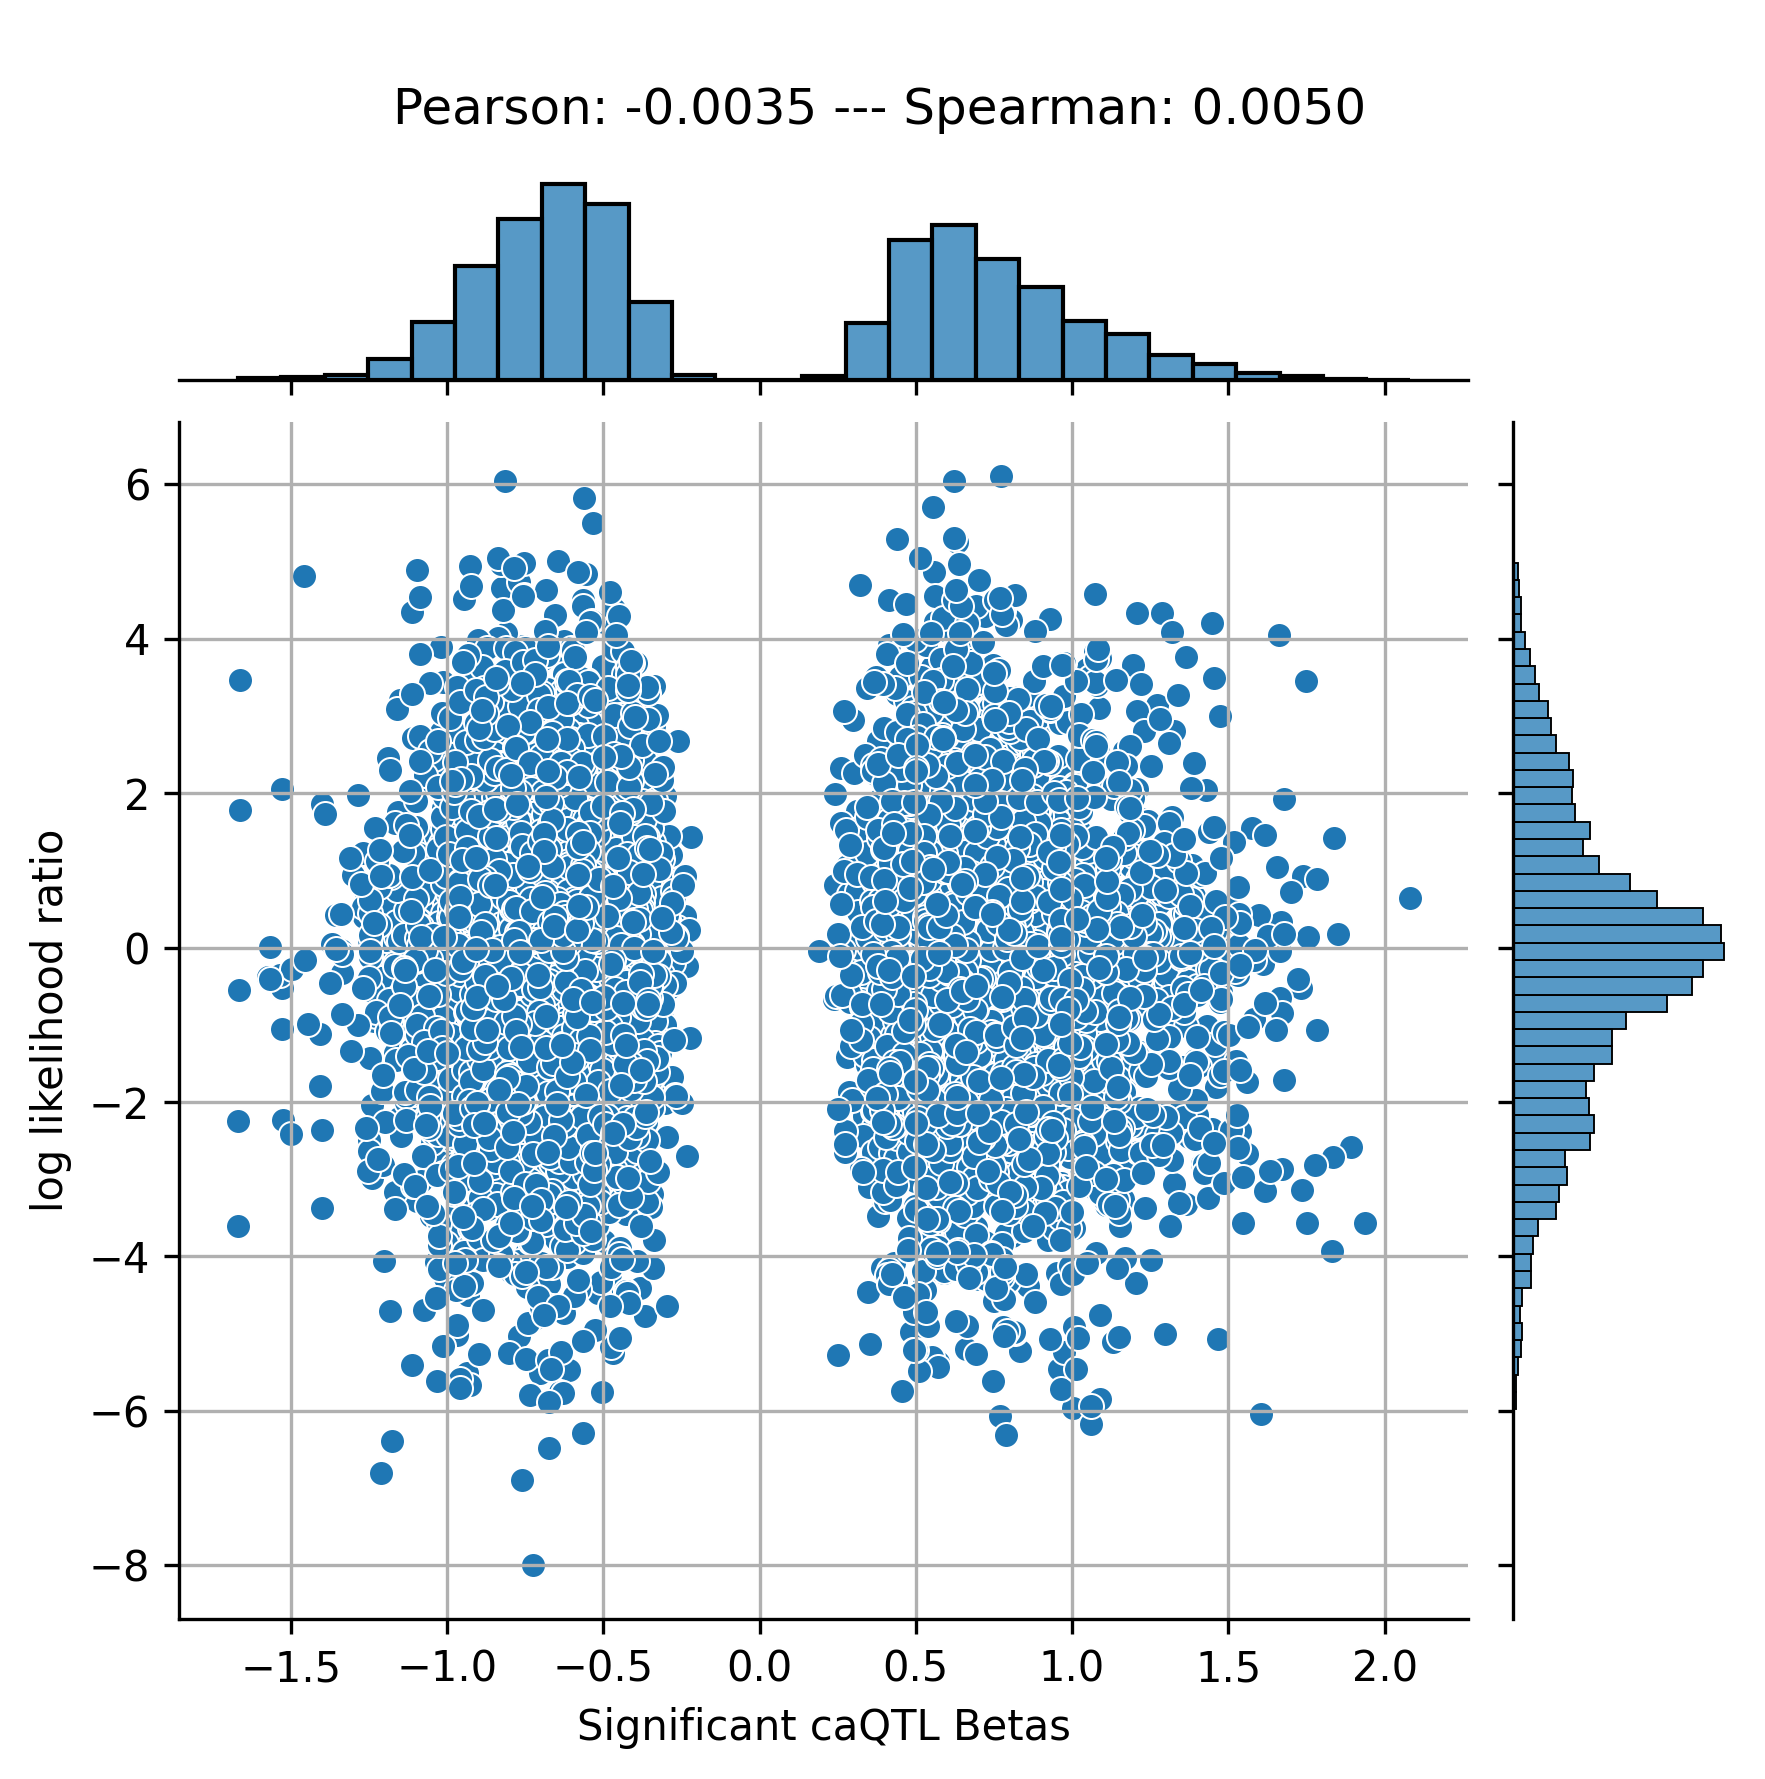

Nucleotide Transformer sig_ctrl_variants_Afr_CaQTLs p-value: 2.1556552276472447e-12
Nucleotide Transformer sig_ctrl_variants_Afr_CaQTLs AUPRC: 0.0920862326783126, AUROC: 0.5252471002268083, Pearson: -0.003506143239462838, Spearman: 0.005012679684523357

+------------------+--------------------------+
| Metric           |   Nucleotide Transformer |
+==================+==========================+
| African P value  |              2.15566e-12 |
+------------------+--------------------------+
| African AUPRC    |              0.0920862   |
+------------------+--------------------------+
| African AUROC    |              0.525247    |
+------------------+--------------------------+
| African Pearson  |             -0.00350614  |
+------------------+--------------------------+
| African Spearman |              0.00501268  |
+------------------+--------------------------+


In [7]:
# 可选参数："afr"、"yoruba"、"both"

afr_metrics, yoruba_metrics = run_all_evaluations(selected_dataset="afr")
display_results(afr_metrics, yoruba_metrics)